# Chapter 5: Convolution and Spatial / Frequency Domain Filtering

In [7]:
%matplotlib inline 
from PIL import Image
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
import numpy.fft as nfp
from scipy import ndimage, misc, signal
from skimage import data, color, restoration, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
import numpy as np
import numpy.fft
import timeit
import warnings
warnings.filterwarnings('ignore')

## Understanding Convolution

0.9921568627450982
(256, 256)


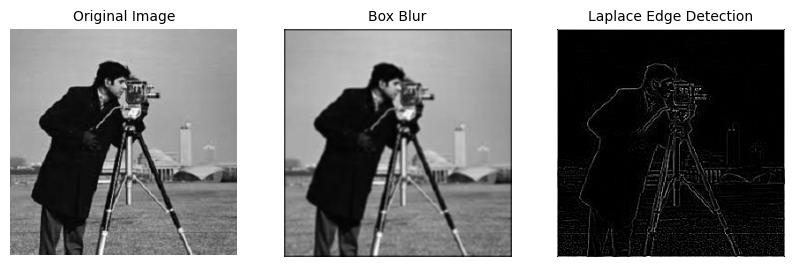

In [177]:
im = rgb2gray(imread('images/cameraman.jpg')).astype(float)
print(np.max(im))
print(im.shape)
blur_box_kernel = np.ones((3,3)) / 9
edge_laplace_kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
im_blurred = signal.convolve2d(im, blur_box_kernel)
im_edges = np.clip(signal.convolve2d(im, edge_laplace_kernel), 0, 1)
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10,4))
axes[0].imshow(im, cmap=plt.cm.gray)
axes[0].set_title('Original Image', size=10)
axes[1].imshow(im_blurred, cmap=plt.cm.gray)
axes[1].set_title('Box Blur', size=10)
axes[2].imshow(im_edges, cmap=plt.cm.gray)
axes[2].set_title('Laplace Edge Detection', size=10)
for ax in axes:
    ax.axis('off')
plt.show()

### Convolution modes, pad values, and boundary conditions

### Applying convolution to a color (RGB) image

1.0
(340, 527, 3)


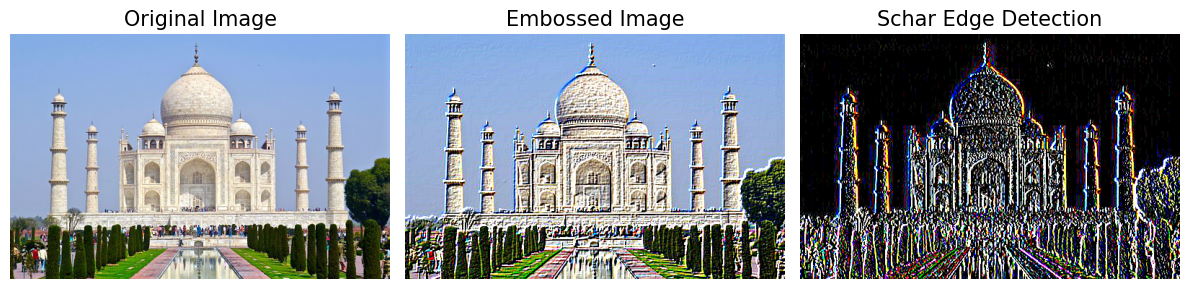

In [164]:
im = imread('images/tajmahal.jpg')
im = im / im.max() # scale each pixel value in [0,1]
print(np.max(im))
print(im.shape)
emboss_kernel = np.array([[-2,-1,0],[-1,1,1],[0,1,2]])
edge_schar_kernel = np.array([[ -3-3j, 0-10j, +3 -3j], [-10+0j, 0+ 0j, +10+0j], [ -3+3j, 0+10j, +3 +3j]])
im_embossed = np.ones(im.shape)
im_edges = np.ones(im.shape)
for i in range(3):
    im_embossed[...,i] = np.clip(signal.convolve2d(im[...,i], emboss_kernel, mode='same', boundary="symm"),0,1)
for i in range(3):
    im_edges[:,:,i] = np.clip(np.real(signal.convolve2d(im[...,i], edge_schar_kernel, mode='same', boundary="symm")),0,1)
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
axes[0].imshow(im)
axes[0].set_title('Original Image', size=15)
axes[1].imshow(im_embossed)
axes[1].set_title('Embossed Image', size=15)
axes[2].imshow(im_edges)
axes[2].set_title('Schar Edge Detection', size=15)
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Convolution with `scipy.ndimage`

With `scipy.ndimage.convolve()`, we can sharpen an RGB image directly (we do not
have to apply the convolution separately for each image channel).
Use the *victoria_memorial* image with $3 \times 3$ **sharpen**, **emboss** and **lighten** kernels defined in the next code snippet:

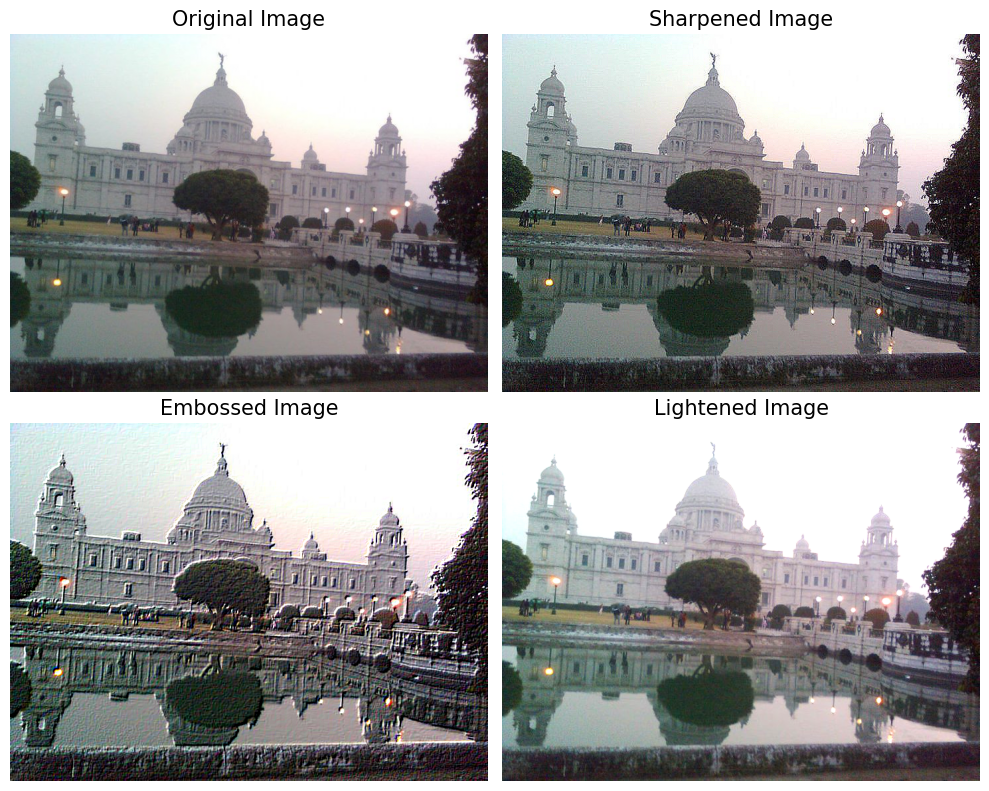

In [178]:
im = imread('images/victoria_memorial.png') # read as float
im = im / im.max()
sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]).reshape((3, 3, 1))
emboss_kernel = np.array([[-2,-1,0],[-1,1,1],[0,1,2]]).reshape((3, 3, 1))
lighten_kernel = (np.array([[0,0,0], [0,12,0], [0,0,0]])/9).reshape((3, 3, 1))

im_sharp = np.clip(ndimage.convolve(im, sharpen_kernel, mode='nearest'), 0, 1) # clip (0 to 255) and convert to unsigned int
im_emboss = np.clip(ndimage.convolve(im, emboss_kernel, mode='nearest'), 0, 1)
im_draw = np.clip(ndimage.convolve(im, lighten_kernel, mode='nearest'), 0, 1)
plt.figure(figsize=(10,8))
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('Original Image', size=15)
plt.subplot(222), plt.imshow(im_sharp), plt.axis('off'), plt.title('Sharpened Image', size=15)
plt.subplot(223), plt.imshow(im_emboss), plt.axis('off'), plt.title('Embossed Image', size=15)
plt.subplot(224), plt.imshow(im_draw), plt.axis('off'), plt.title('Lightened Image', size=15)
plt.tight_layout()
plt.show()

### Convolution with `opencv-python`

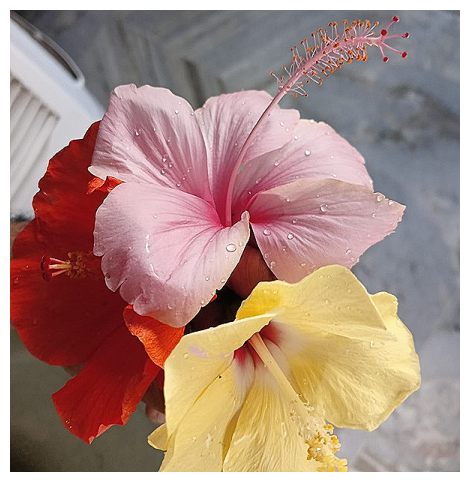

In [179]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a grayscale image
image = cv2.cvtColor(cv2.imread('images/hibiscus.jpeg'), cv2.COLOR_BGR2RGB)

# Define a simple 3x3 sharpening kernel
kernel = np.array([[ 0, -1,  0],
                   [-1,  5, -1],
                   [ 0, -1,  0]], dtype=np.float32)

# Apply 2D convolution using filter2D()
filtered_image = cv2.filter2D(image, ddepth=-1, kernel=kernel)
plt.figure(figsize=(6,6))
plt.imshow(filtered_image), plt.axis('off');

### Benchmarking the performance of convolution implementations

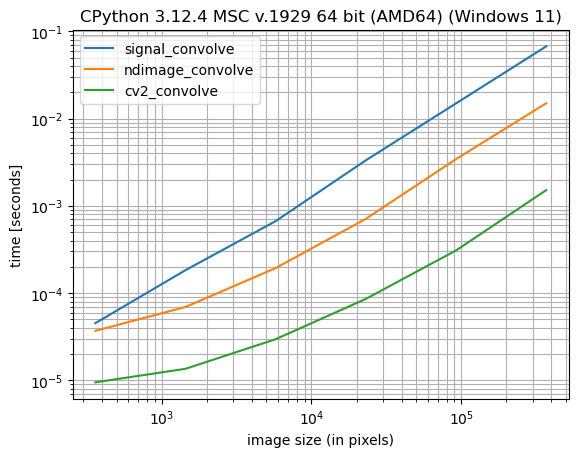

In [133]:
from simple_benchmark import benchmark
from datetime import timedelta

image = cv2.cvtColor(cv2.imread('images/hibiscus.jpeg'), cv2.COLOR_BGR2RGB)
num_pixels = np.prod(image.shape[:2])
kernel = np.array([[ 0, -1,  0],
                   [-1,  5, -1],
                   [ 0, -1,  0]], dtype=np.float32)

def signal_convolve(im):
    im_out = np.zeros_like(im)
    for i in range(3):
        im_out[...,i] = signal.convolve2d(im[...,i], kernel, mode='same', boundary="symm")
    return im_out

def ndimage_convolve(im):
    return ndimage.convolve(im, kernel[:,:,np.newaxis], mode='nearest')

def cv2_convolve(im):
    return cv2.filter2D(im, ddepth=-1, kernel=kernel)

b = benchmark(
    [signal_convolve, ndimage_convolve, cv2_convolve],
    {num_pixels*2**(-2*i): cv2.resize(image, None, fx=2**(-i), fy=2**(-i)) for i in range(5,-1,-1)},
    time_per_benchmark=timedelta(milliseconds=500),
    maximum_time=timedelta(milliseconds=500)
)

b.plot()
plt.xlabel('image size (in pixels)', size=10);

## Correlation vs. Convolution

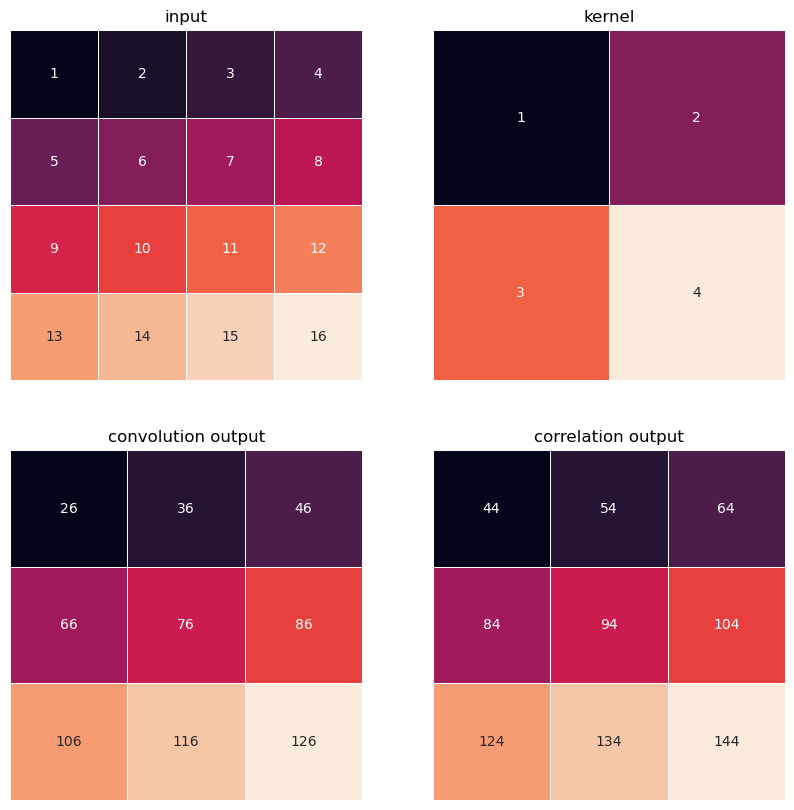

In [6]:
from scipy.signal import convolve2d, correlate2d
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

k = np.reshape(range(1,5), (2,2))
I = np.reshape(range(1,17), (4,4))
conv_out = convolve2d(I, k, mode='valid')
corr_out = correlate2d(I, k, mode='valid')
#print(k, I, C1, C2)
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()
sns.heatmap(I, annot=True, fmt="d", linewidths=.5, ax=ax[0], cbar=False), 
sns.heatmap(k, annot=True, fmt="d", linewidths=.5, ax=ax[1], cbar=False)
sns.heatmap(conv_out, annot=True, fmt="d", linewidths=.5, ax=ax[2], cbar=False)
sns.heatmap(corr_out, annot=True, fmt="d", linewidths=.5, ax=ax[3], cbar=False)
titles = ['input', 'kernel', 'convolution output', 'correlation output']
for i in range(4):
    ax[i].set_title(titles[i])
    ax[i].axis('off')
plt.show()

### Template matching

#### using cross-correlation

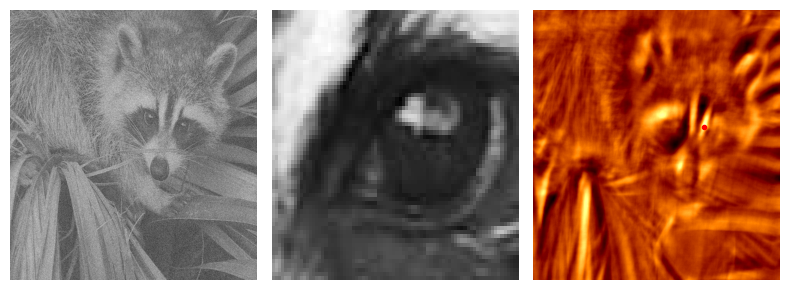

In [165]:
face_image = misc.face(gray=True) - misc.face(gray=True).mean()
template_image = np.copy(face_image[300:365, 670:750]) # right eye
template_image -= template_image.mean()
# add random noise
face_image = face_image + np.random.randn(*face_image.shape) * 50 
cc = signal.correlate2d(face_image, template_image,\
                                 boundary='symm', mode='same')
# find the match
y, x = np.unravel_index(np.argmax(cc), cc.shape)
# plot face_image, template_image, correlation (use cmap='afmhot')
plt.figure(figsize=(8,3))
plt.gray()
plt.subplot(131), plt.imshow(face_image, aspect='auto'), plt.axis('off')
plt.subplot(132), plt.imshow(template_image, aspect='auto'), plt.axis('off')
plt.subplot(133), plt.imshow(cc, cmap='afmhot', aspect='auto'), plt.plot(x, y, 'r.'), plt.axis('off')
plt.tight_layout()

#### using normalized cross-correlation

Cross-correlation measures similarity between an image $I$ and a template $T$, but it is sensitive to variations in lighting and contrast. Normalized cross-correlation (**NCC**) overcomes this issue by normalizing both the image and template, ensuring the correlation values remain between 
$[−1,1]$, making them scale and illumination invariant.

Mathematical Definition of NCC
The normalized cross-correlation at position $(x,y)$ is given by:

$${NCC}(x, y) = \frac{\sum_{i,j} \left( I(x+i, y+j) - \mu_I \right) \left( T(i,j) - \mu_T \right)}{\sqrt{\sum_{i,j} \left( I(x+i, y+j) - \mu_I \right)^2 \sum_{i,j} \left( T(i,j) - \mu_T \right)^2}}$$
​
where $μ_I$ and $μ_T$ are the mean values of the image patch and template, respectively. The numerator computes the zero-mean cross-correlation.
The denominator normalizes by the standard deviations, ensuring scale invariance.

**with** `scipy.signal`

In [185]:
def normalized_cross_correlation(image, template):
    # Compute means
    template_mean = np.mean(template)
    image_mean = signal.correlate2d(image, np.ones(template.shape), mode='valid') / template.size
    
    # Compute zero-mean template
    template_zero_mean = template - template_mean
    
    # Compute numerator: cross-correlation of zero-mean template with image
    numerator = signal.correlate2d(image, template_zero_mean, mode='valid')
    
    # Compute denominator: standard deviations
    image_std = np.sqrt(signal.correlate2d(image**2, np.ones(template.shape), mode='valid') / template.size - image_mean**2)
    template_std = np.std(template)
    
    # Avoid division by zero
    denominator = image_std * template_std
    denominator[denominator == 0] = 1e-10  # Small epsilon to prevent NaN values
    
    # Compute NCC
    ncc = numerator / denominator
    
    return ncc

ncc = normalized_cross_correlation(face_image, template_image)

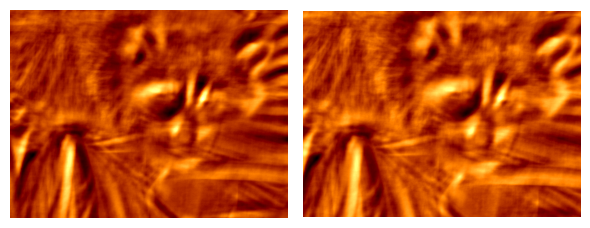

In [186]:
plt.figure(figsize=(6,4))
plt.subplot(121), plt.imshow(cc, cmap='afmhot'), plt.axis('off')
plt.subplot(122), plt.imshow(ncc, cmap='afmhot'), plt.axis('off')
plt.tight_layout()

**with** `opencv-python`

In [ ]:
import cv2
ncc2 = cv2.matchTemplate(face_image.astype(np.uint8), template_image.astype(np.uint8), method=cv2.TM_CCOEFF_NORMED)

# Plot the NCC result
plt.imshow(ncc2, cmap='afmhot'), plt.axis('off')

### Application of the convolution theorem

### Frequency domain Gaussian blur filter with `numpy.fft`

The following code block shows how to apply a Gaussian filter in the frequency domain using the convolution theorem and `numpy.fft` (since in the frequency domain it is simply multiplication). The following figure shows the output of the preceding code, the original lena image, the kernel, and the output image obtained after convolution, both in the spatial and frequency domains:

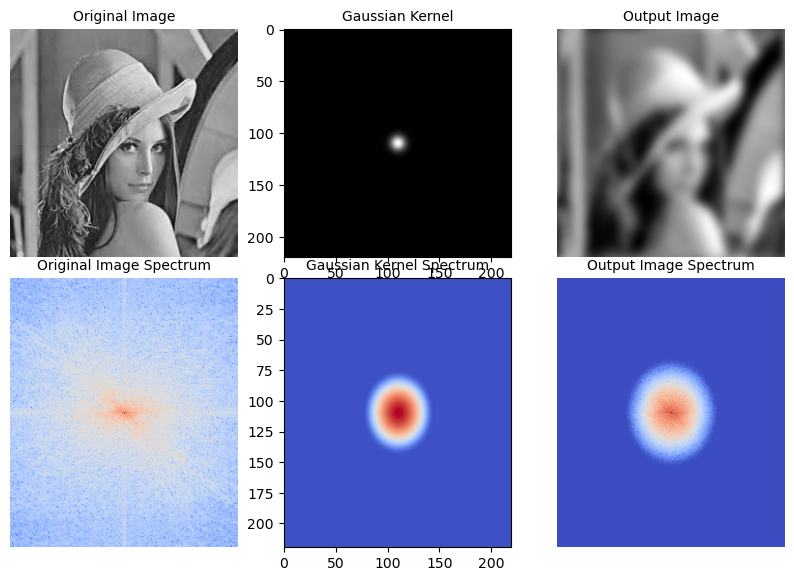

In [167]:
def plot_spectrum(F, method=None, cmap='coolwarm'):
    F_disp = (20*np.log10(0.01 + np.abs(F))).astype(int) if method == 'log' else np.minimum(np.abs(F).astype(int)+100, 255) 
    plt.imshow(F_disp, cmap=cmap, aspect='auto')

plt.figure(figsize=(10,7))
plt.gray() # show the filtered result in grayscale
im = np.mean(imread('images/lena.jpg'), axis=2)
gauss_kernel = np.outer(signal.windows.gaussian(im.shape[0], 5), signal.windows.gaussian(im.shape[1], 5))
freq = fp.fft2(im)
assert(freq.shape == gauss_kernel.shape)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel))
convolved = freq*freq_kernel # by the convolution theorem, simply multiply in the frequency domain
im1 = fp.ifft2(convolved).real

plt.subplot(231), plt.imshow(im), plt.title('Original Image', size=10), plt.axis('off')
plt.subplot(232), plt.imshow(gauss_kernel), plt.title('Gaussian Kernel', size=10)
plt.subplot(233), plt.imshow(im1) # the imaginary part is an artifact
plt.title('Output Image', size=10), plt.axis('off')
plt.subplot(234), plot_spectrum(fp.fftshift(freq), 'log')
plt.title('Original Image Spectrum', size=10), plt.axis('off')
plt.subplot(235), plot_spectrum(fp.fftshift(freq_kernel), 'log')
plt.title('Gaussian Kernel Spectrum', size=10), plt.subplot(2,3,6)
plot_spectrum(fp.fftshift(convolved), 'log')
plt.title('Output Image Spectrum', size=10), plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()

## The Gaussian LPF kernel 

In [8]:
im = rgb2gray(imread('images/lena.jpg'))
gauss_kernel = np.outer(signal.windows.gaussian(im.shape[0], 1), \
                        signal.windows.gaussian(im.shape[1], 1))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel))
convolved = freq*freq_kernel # by the convolution theorem, simply multiply in the frequency domain

### with a 2D plot

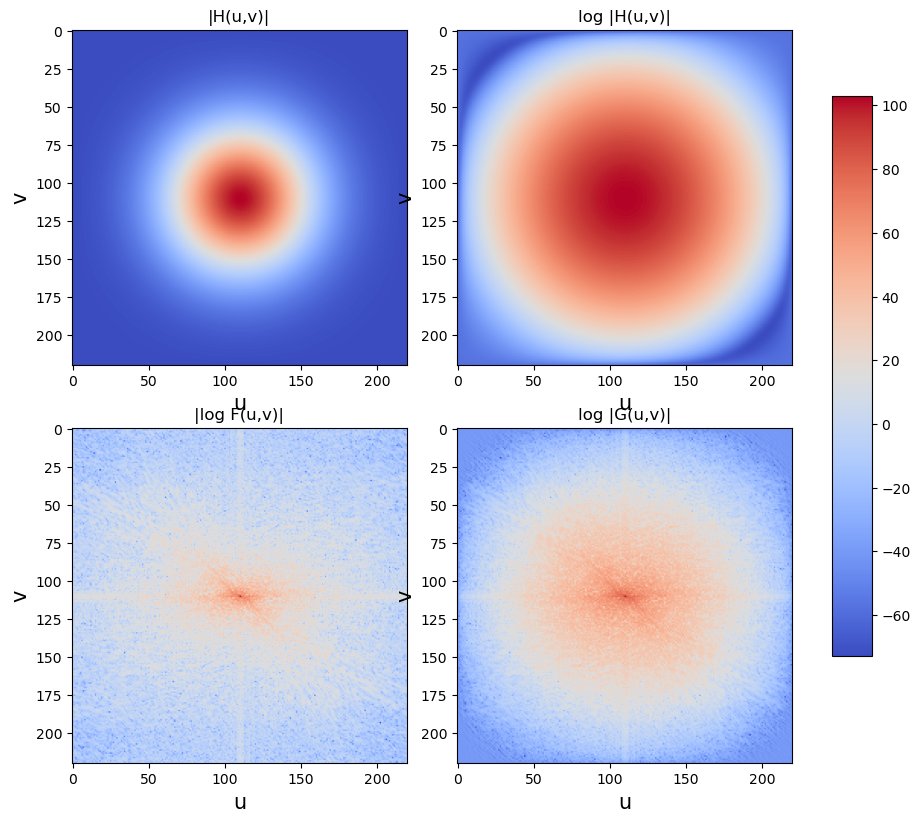

In [47]:
def plot_spectrum_2d(F, ax, log=True, cmap='coolwarm', title=''):
    # fp.fftshift(F).real
    im = ax.imshow(np.abs(fp.fftshift(F)), cmap='coolwarm') if not log \
                   else ax.imshow(20*np.log10( 0.01 + fp.fftshift(F)).real, cmap='coolwarm') 
    # 0.01 is added to keep the argument to log function always positive
    ax.set_title(title)
    ax.set_xlabel('u', size=15)
    ax.set_ylabel('v', size=15)
    return im

fig, axes =	plt.subplots(nrows=2, ncols=2, figsize=(8,8))
axes = axes.ravel()
plot_spectrum_2d(freq_kernel, axes[0], False, title='|H(u,v)|')
plot_spectrum_2d(freq_kernel, axes[1], title='log |H(u,v)|')
plot_spectrum_2d(freq, axes[2], title='|log F(u,v)|')
im = plot_spectrum_2d(convolved, axes[3], title='log |G(u,v)|')
fig.subplots_adjust(0, 0, 0.9, 0.95, 0.15, 0.1)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

### with 3d plot

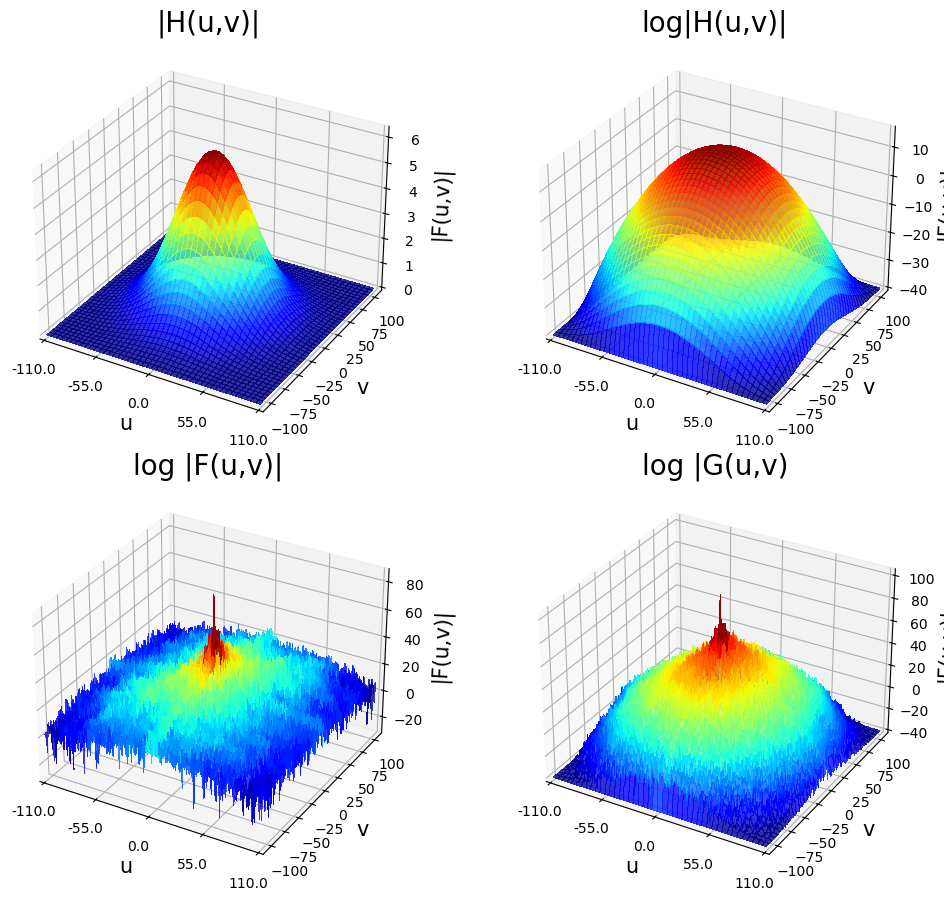

In [46]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_spectrum_3d(F, ax, cmap='jet', title=''):
 h, w = F.shape[0], F.shape[1]
 X, Y = range(-h//2, h-h//2), range(-w//2, w-w//2)
 Y, X = np.meshgrid(X, Y)
 surf = ax.plot_surface(X, Y, F, cmap=cmap, linewidth=0, antialiased=False, rstride=5,	cstride=5,	alpha=0.8)
 ax.set_xlim(-h//2, h//2)
 ax.set_ylim(-w//2, w//2)
 ax.xaxis.set_major_locator(LinearLocator(5))
 ax.xaxis.set_major_formatter(FormatStrFormatter('%.01f'))
 #ax.view_init(elev=10.) #,	azim=5)
 ax.set_title(title,	size=20)
 ax.set_xlabel('u', size=15)
 ax.set_ylabel('v', size=15)
 ax.set_zlabel('|F(u,v)|', size=15)

fig, axes =	plt.subplots(subplot_kw={"projection": "3d"}, nrows=2, ncols=2, figsize=(11,9))
axes = axes.ravel()
plot_spectrum_3d(np.abs(fp.fftshift(freq_kernel)), axes[0], title='|H(u,v)|')
plot_spectrum_3d(20*np.log10( 0.01 + np.abs(fp.fftshift(freq_kernel))), axes[1], title='log|H(u,v)|')
plot_spectrum_3d(20*np.log10( 0.01 + np.abs(fp.fftshift(freq))), axes[2], title='log |F(u,v)|')
plot_spectrum_3d(20*np.log10( 0.01 + np.abs(fp.fftshift(convolved))), axes[3], title='log |G(u,v)')
plt.tight_layout()
plt.show()

### Frequency domain Gaussian blur filter with `scipy.signal.fftconvolve()`

The following code block shows how the `scipy.signal` module's `fftconvolve()` function
can be used to run the convolution in the frequency domain (internally by just a
multiplication and the convolution theorem). The following screenshot shows the output of the preceding code block in the spatial
domain:

(224, 225)


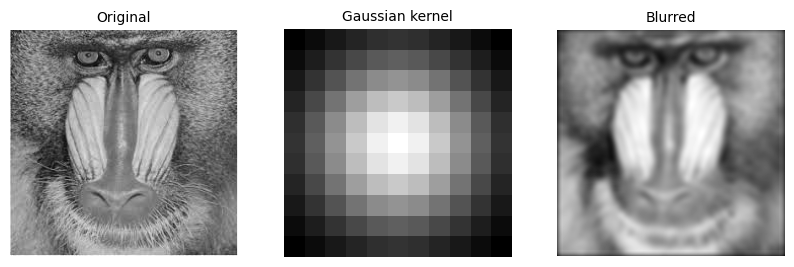

In [190]:
im = np.mean(plt.imread('images/mandrill.jpg'), axis=2)
print(im.shape)
# (224, 225)
gauss_kernel = np.outer(signal.windows.gaussian(11, 3), signal.windows.gaussian(11, 3)) # 2D Gaussian kernel of size 11x11 with σ = 3
im_blurred = signal.fftconvolve(im, gauss_kernel, mode='same')
fig, (ax_original, ax_kernel, ax_blurred) = plt.subplots(1, 3, figsize=(10,5))
ax_original.imshow(im, cmap='gray')
ax_original.set_title('Original', size=10)
ax_original.set_axis_off()
ax_kernel.imshow(gauss_kernel, cmap='gray')
ax_kernel.set_title('Gaussian kernel', size=10)
ax_kernel.set_axis_off()
ax_blurred.imshow(im_blurred, cmap='gray')
ax_blurred.set_title('Blurred', size=10)
ax_blurred.set_axis_off()
fig.show()

The following code block shows how to plot the original and the blurred image spectrum after convolution. The following figure shows the output of the preceding code block in the frequency domain:

In [ ]:
F1 = fp.fft2((im).astype(float))
F2 = fp.fftshift( F1 )
plt.figure(figsize=(15,8))
plt.subplot(1,2,1), plot_spectrum(F2, 'log', cmap=plt.cm.gray)
plt.title('Original Image Spectrum', size=20)
F1 = fp.fft2((im_blurred).astype(float))
F2 = fp.fftshift( F1 )
plt.subplot(1,2,2), plot_spectrum(F2, 'log', cmap=plt.cm.gray)
plt.title('Blurred Image Spectrum', size=20)
plt.show()

The same code block as the previous one is used to compute a blurred version of the
Victoria Memorial Hall image, but this time the `fftconvolve()` function is invoked with a
larger ($50 \times 50$) Gaussian kernel with σ=10. The following screenshot shows the output of
the same code with the new image and the modified kernel:

![](images/LPF_vic.png)

### Comparing the runtimes of `scipy.convolve()` and `fftconvolve()` with the Gaussian blur kernel

We can use the Python `timeit` module to compare the runtimes of the image domain and
the frequency domain convolution functions. Since the frequency domain convolution
involves a single matrix multiplication instead of a series of sliding window arithmetic
computations, it is expected to be much faster. The following code block displays the original **Mandrill** image, as well as the blurred images, using both functions. If you run  the next code snippet you will obtain the following figure. As expected, both the `convolve()` and `fftconvolve()` functions result in the same blurred output image:

(224, 225)


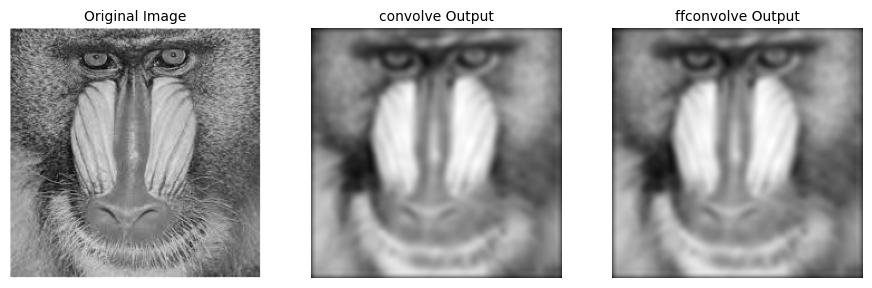

In [243]:
im = np.mean(plt.imread('images/mandrill.jpg'), axis=2)
print(im.shape)
# (224, 225)
gauss_kernel = np.outer(signal.windows.gaussian(11, 3), signal.windows.gaussian(11, 3)) # 2D Gaussian kernel of size 11x11 with σ = 3
im_blurred1 = signal.convolve(im, gauss_kernel, mode="same")
im_blurred2 = signal.fftconvolve(im, gauss_kernel, mode='same')

plt.figure(figsize=(11,5))
plt.gray()
plt.subplot(131), plt.imshow(im), plt.title('Original Image',size=10), plt.axis('off')
plt.subplot(132), plt.imshow(im_blurred1), plt.title('convolve Output', size=10), plt.axis('off')
plt.subplot(133), plt.imshow(im_blurred2), plt.title('ffconvolve Output', size=10),plt.axis('off')
plt.show()

The following code compares the runtimes and visualizes the difference in between runtimes. Each of the functions has
been run on the same input image with the same Gaussian kernel $100$ times and then the
boxplot of the times taken for each function is plotted. As can be seen, `fftconvolve()` runs faster on average:

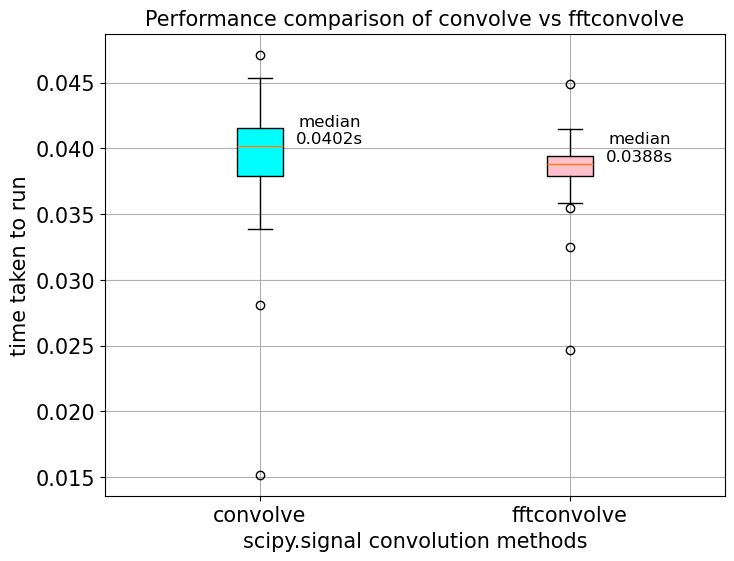

In [82]:
import scipy.signal
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

np.random.seed(1)

#im = rgb2gray(imread('images/mandrill.jpg'))
im = resize(rgb2gray(imread('images/mandrill.jpg')), (512, 512))
# print(im.shape)
# (512, 512)
k = 31
gauss_kernel = np.outer(signal.windows.gaussian(2*k+1, 3), signal.windows.gaussian(2*k+1, 3)) # 2D Gaussian kernel of size 11x11 with σ = 3

def wrapper_convolve(func):
    def wrapped_convolve():
        return func(im, gauss_kernel, mode="same")
    return wrapped_convolve

wrapped_convolve = wrapper_convolve(signal.convolve)       # spatial domain implementation
wrapped_fftconvolve = wrapper_convolve(signal.fftconvolve) # frequency domain implementation

times1 = timeit.repeat(wrapped_convolve, number=1, repeat=100)
times2 = timeit.repeat(wrapped_fftconvolve, number=1, repeat=100)

# Prepare plot
data = [times1, times2]
plt.figure(figsize=(8,6))
box = plt.boxplot(data, patch_artist=True) #notch=True,
colors = ['cyan', 'pink']
labels = ['convolve', 'fftconvolve']

# Add colors and median labels
for i, (patch, color, times) in enumerate(zip(box['boxes'], colors, data)):
    patch.set_facecolor(color)
    median = np.median(times)
    plt.text(i + 1 + 0.225, median, f'median\n{median:.4f}s', ha='center', va='bottom', fontsize=12, color='black')

# Final formatting
plt.xticks([1, 2], labels, size=15)
plt.yticks(fontsize=15)
plt.xlabel('scipy.signal convolution methods', size=15)
plt.ylabel('time taken to run', size=15)
plt.title('Performance comparison of convolve vs fftconvolve', fontsize=15)
plt.grid(True)
plt.show()

## 2D vs. 3D convolution

### 2D convolution

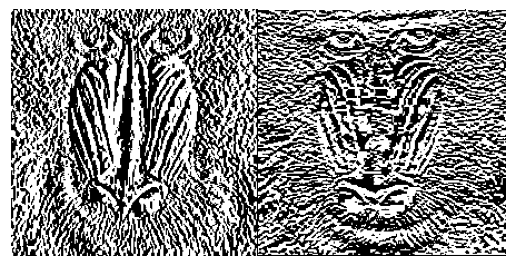

In [27]:
import torch 
import torch.nn.functional as F  
im = torch.from_numpy(np.mean(plt.imread('images/mandrill.jpg'), \
                                                axis=2)).float()
 
# creating the kernels  
# vertical kernel  
VK = torch.Tensor([ [1,0,-1],  
                [1,0,-1],  
                [1,0,-1] ]).view(1, 1, 3, 3) # kernel has to have a 
                                             # specific format  
# horizontal kernel  
HK = torch.Tensor([ [ 1, 1, 1],  
                [ 0, 0, 0],  
                [-1,-1,-1] ]).view(1, 1, 3, 3)  

C1 = F.conv2d(im.reshape(1,1,im.shape[0], im.shape[1]),VK) 
C2 = F.conv2d(im.reshape(1,1,im.shape[0], im.shape[1]),HK) 
C1, C2 = np.clip(C1.squeeze().numpy(),0,1), \
         np.clip(C2.squeeze().numpy(),0,1)

plt.gray()
plt.imshow(np.hstack((C1, C2))), plt.axis('off');

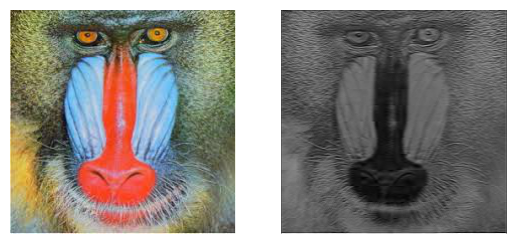

In [28]:
im = plt.imread('images/mandrill.jpg')
im = im / im.max()
im = torch.from_numpy(im).float()
 
# creating the kernel  
k = np.array([ [0,-1,0],  [-1,5,-1],  [0,-1,0] ])
K = np.repeat(k[:, :, np.newaxis], 3, axis=2) 
K = torch.Tensor(K).view(1, 3, 3, 3)
C = F.conv2d(im.permute(2,0,1)[None,...],K,  padding = "same") 
C = C.squeeze()

plt.gray()
plt.subplot(121), plt.imshow(im), plt.axis('off')
plt.subplot(122), plt.imshow(C.numpy()), plt.axis('off');

### 3D convolution

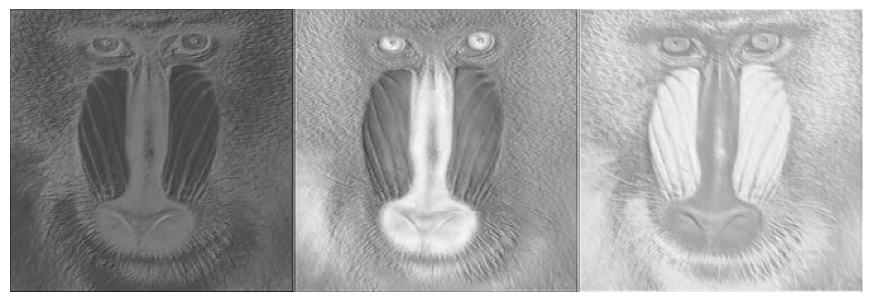

In [32]:
import torch 
im = plt.imread('images/mandrill.jpg')
im = im / im.max()
im = torch.from_numpy(im).float()
im = im.permute(2,0,1)[None,None,...]

K = torch.hstack((torch.Tensor([ [1,0,-1],  \
                			      [1,0,-1],  \
                                [1,0,-1] ]), \
                  torch.Tensor([ [ 1, 1, 1],  \
                			      [ 0, 0, 0],  \
                			      [-1,-1,-1] ]), \
                  torch.ones(3,3)/9)).view(1, 3, 3, 3)

C = F.conv3d(im, K[None,...],  padding = "same")
C = C.squeeze()

plt.figure(figsize=(11,5))
plt.gray()
plt.imshow(np.hstack(((C[0,...].numpy()), 
                        C[1,...].numpy(), 
                        C[2,...].numpy())))
plt.axis('off');

## Upsampling vs. Transposed Convolution 

In [128]:
import torch
from torchvision.io import read_image, ImageReadMode
import torch.nn as nn

def show(img):
    img = img.squeeze().squeeze().numpy()
    img = (255*img).astype(np.uint8)
    return(Image.fromarray(img))
   
im = read_image('images/peppers.png', mode=ImageReadMode.GRAY).to(torch.float32)
im = im[None, :3, ...]
im = im / im.max()

with torch.no_grad():
    kernel = torch.tensor([[1,2,1], [2,4,2], [1,2,1]], dtype=torch.float32)
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    upsample_conv = nn.ConvTranspose2d(1, 1, 3, stride=2, padding=0, bias=False)
    # Assign fixed kernel
    upsample_conv.weight = nn.Parameter(kernel)
    # upsample_conv.weight.copy_(kernel.view(1, 1, 3, 3))
    # Disable gradient updates
    upsample_conv.weight.requires_grad = False
    im_uc1 = upsample_conv(im)             
    upsample = nn.Upsample(scale_factor=2) 
    conv = nn.Conv2d(1, 1, 3, stride=1, padding='same', bias=False)
    conv.weight = nn.Parameter(kernel)
    im_uc2 = conv(upsample(im))
print(im.shape, im_uc1.shape, im_uc2.shape)

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 1025, 1025]) torch.Size([1, 1, 1024, 1024])


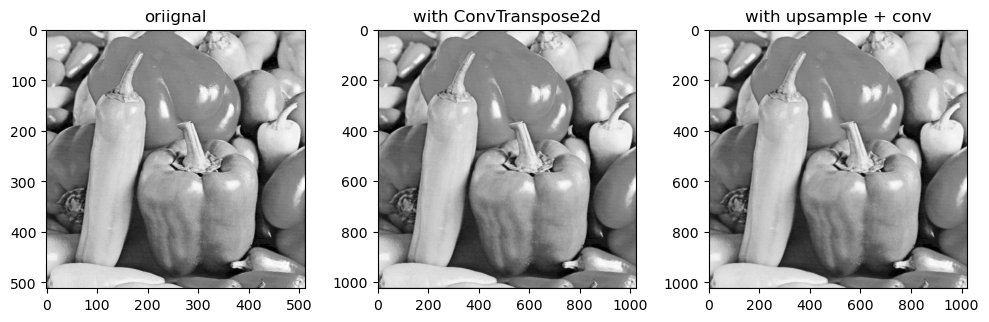

In [131]:
plt.figure(figsize=(10,4))
plt.gray()
plt.subplot(131), plt.imshow(im.squeeze().numpy()), plt.title('oriignal')
plt.subplot(132), plt.imshow(im_uc1.squeeze().numpy()), plt.title('with ConvTranspose2d') 
plt.subplot(133), plt.imshow(im_uc2.squeeze().numpy()), plt.title('with upsample + conv') 
plt.tight_layout()
plt.show()

## Questions

### Question 1  

**Correlation vs. Convolution**: Use the Lena image and the $3 \times 3$ asymmetric **ripple kernel** given by $$\begin{bmatrix}0 & -1 & \sqrt{2}\\1 & 0 & -1\\ -\sqrt{2} & 1 & 0\end{bmatrix}$$ to generate images with **correlation** and **convolution**. Show that output images are different. Now, **flip** the kernel twice (upside-down and left-right) and apply the correlation with the flipped kernel - is the output image the same as the one obtained using the original kernel with convolution?

### Question 2

Use `scipy.signal`’s `fftconvolve()` function to apply a Gaussian blur on a RGB color image in the frequency domain.

### Question 3

Use the `fourier_uniform()` and `fourier_ellipsoid()` functions of the `scipy.ndimage` module to apply LPFs with box and ellipsoid kernels, respectively, on an image in the frequency domain.

### Question 4

Let us explore the behavior of a 2D rotated Gaussian low-pass filter and its effect on an image's frequency spectrum. Your task is to generate an animation that applies Gaussian filters with varying standard deviations and visualizes how both the spatial and frequency domains are affected. Create an animation using Python that demonstrates the effect of applying a rotated 2D Gaussian filter to an image in the frequency domain. The animation should:

- Load a grayscale image (e.g., Lena or Cameraman).
- Construct a non-separable rotated Gaussian kernel for each frame, varying the standard deviation (σ).
- Apply the kernel in the frequency domain using the convolution theorem (multiplication in the frequency domain).
- Display, side-by-side for each frame:
  - The original image
  - The Gaussian kernel in the spatial domain
  - The filtered image
  - The log-magnitude frequency spectrum of the original image
  - The spectrum of the Gaussian kernel
  - The spectrum of the filtered output
- Use `matplotlib.animation.FuncAnimation` to generate the animation inline in a Jupyter notebook.

💡 Hints

- Use `np.meshgrid()` and rotation matrices to generate a rotated 2D Gaussian (not constructed with `np.outer()`).
- Use `scipy.fftpack.fft2()` and `ifft2()` for frequency transformations.
- Use `fftshift()` and log scaling `(log(1 + abs(F)))` for better visualization of frequency spectra.
- Vary $σ$ from $5$ to $50$.
- Normalize the filtered output image for consistent brightness across frames.

You should obtain an animation shown below:

![](images/ff.gif)